In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import requests

pd.set_option('precision',1)

In [171]:
year = '2017'

In [176]:
%run jawbone.py $year

In [276]:
from jawbone_data import JawboneData
data = JawboneData(year)

In [277]:
data.summary_statistics()

Summary statistics for minutes spent in each phase

       s_light  s_clinical_deep  s_rem
count     35.0             35.0   35.0
mean     266.1             73.9  129.9
std       79.4             33.1   43.4
min      112.2             20.2   16.6
25%      205.0             54.8  102.5
50%      267.1             64.8  130.8
75%      332.2             86.0  151.7
max      408.5            160.7  250.2

Summary statistics for minutes of total sleep time

       s_duration
count        35.0
mean        469.9
std          86.1
min         229.2
25%         419.7
50%         482.6
75%         531.6
max         619.2

Summary statistics for time of sleep onset (midnight = 0)

       s_asleep_time
count           35.0
mean            71.3
std             92.2
min            -74.1
25%             11.4
50%             49.6
75%            132.8
max            353.6

Summary statistics for percent of sleep spent in each phase

       s_light  s_clinical_deep  s_rem
count     35.0             35.0 

In [174]:
df = pd.read_csv('2017.csv')

In [175]:
df_data = pd.DataFrame([df.iloc[i,:] for i in df.index if df.iloc[i,:]['s_rem'] > 0])

In [87]:
sleep_cols = [u's_light', u's_clinical_deep', u's_rem', u's_duration', u's_asleep_time']

In [88]:
df_sleep = df_data[sleep_cols]

In [90]:
df_sleep_mins = df_sleep[cycle_cols] / 60.

In [268]:
from time import strptime, strftime

In [269]:
sleep_data_days = [strptime(year + '{:0=3}'.format(ind+1), '%Y%j') for ind in df_sleep_mins.index]

In [92]:
df_sleep_fractions = df_sleep_mins.copy()
for col in df_sleep_fractions.columns[:3]:
    df_sleep_fractions.loc[:,col] = 100. * df_sleep_mins.loc[:,col] / df_sleep_mins['s_duration']

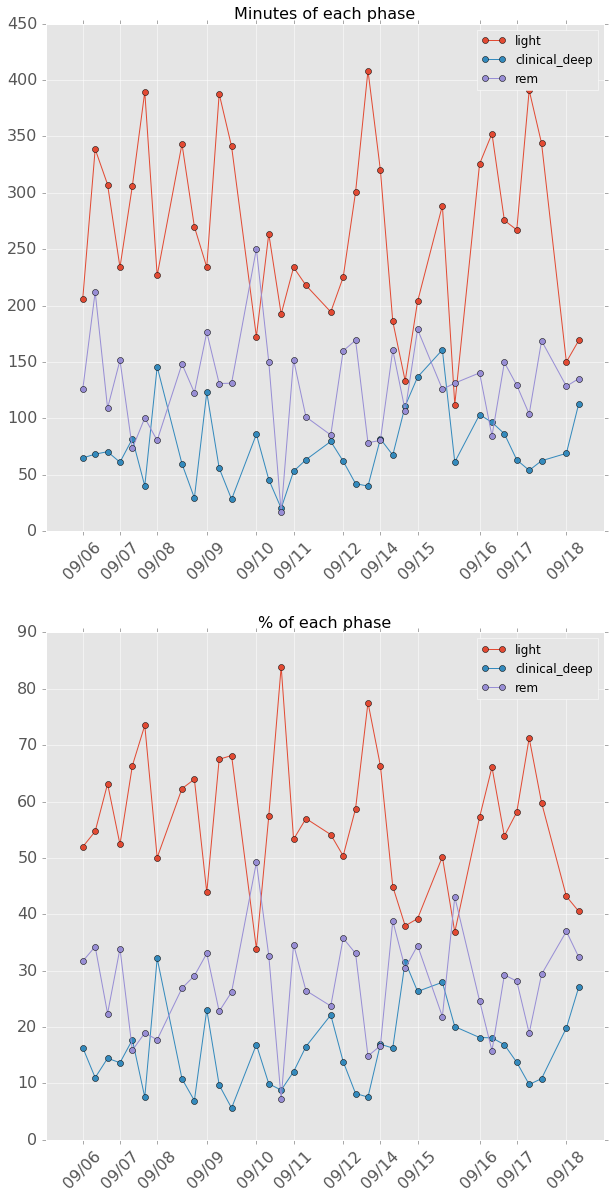

In [275]:
plt.figure(figsize=(10,20))

plt.subplot(211)
for col in df_sleep_mins.columns[:3]:
    plt.plot(df_sleep_mins.loc[:,col],'o-',label=col[2:])
plt.legend();
plt.title('Minutes of each phase', size=16);
plt.yticks(size=16)
plt.xticks(df_sleep_mins.index[0::3], 
           [strftime('%m/%d', st) for st in sleep_data_days],
          rotation=45, size=16);

plt.subplot(212)
for col in df_sleep_fractions.columns[:3]:
    plt.plot(df_sleep_fractions.loc[:,col],'o-',label=col[2:])
plt.legend();
plt.title('% of each phase', size=16);
plt.yticks(size=16)
plt.xticks(df_sleep_fractions.index[0::3], 
           [strftime('%m/%d', st) for st in sleep_data_days],
          rotation=45, size=16);

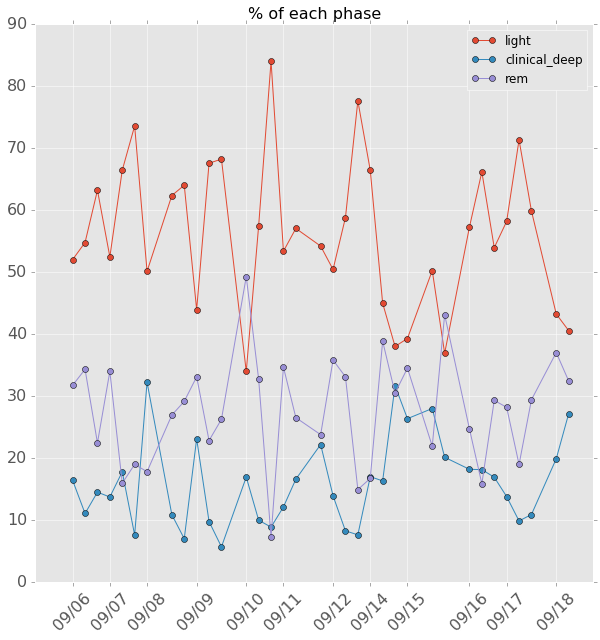

In [267]:
plt.figure(figsize=(10,10))
for col in df_sleep_fractions.columns[:3]:
    plt.plot(df_sleep_fractions.loc[:,col],'o-',label=col[2:])
plt.legend();
plt.title('% of each phase', size=16);
plt.yticks(size=16)
plt.xticks(df_sleep_fractions.index[0::3], 
           [strftime('%m/%d', st) for st in sleep_data_days],
          rotation=45, size=16);

In [255]:
plt.

In [107]:
df_lifestyle = pd.read_csv('lifestyle_variables.csv')

In [122]:
lifestyle_var_names = list(df_lifestyle.columns[1:])

In [108]:
date_after_formatted = ['/'.join([('0' * (2-len(s)) + s) for s in row])
  for row in [s.split('/') for s in df_lifestyle['date_after']]
  ]

df_lifestyle['date_after'] = date_after_formatted

In [110]:
day_of_year = [strptime(s,'%m/%d/%y').tm_yday - 1 for s in df_lifestyle['date_after']]
df_lifestyle['day_of_year'] = day_of_year

In [111]:
df_lifestyle = df_lifestyle.set_index('day_of_year')

In [112]:
df_sleep_mins_full = df_sleep_mins.join(df_lifestyle, how='inner').drop('date_after', axis=1)
df_sleep_fractions_full = df_sleep_fractions.join(df_lifestyle, how='inner').drop('date_after', axis=1)

In [113]:
from sklearn.linear_model import LinearRegression
lr_rem = LinearRegression()

lr_rem.fit(np.expand_dims(df_sleep_mins['s_duration'],1), df_sleep_mins['s_rem'])

print lr_rem.coef_
print lr_rem.intercept_

[ 0.2211105]
26.0356629106


In [114]:
lr_rem = sm.OLS(df_sleep_mins['s_rem'], sm.add_constant(df_sleep_mins['s_duration'])).fit()
rem_latency =  lr_rem.fittedvalues - df_sleep_mins['s_rem']

In [115]:
df_sleep_mins_lat = df_sleep_mins.copy()
df_sleep_mins_lat['rem_lat'] = rem_latency

In [116]:
df_sleep_mins_full_lat = df_sleep_mins_lat.join(df_lifestyle, how='inner').drop('date_after', axis=1)

Regression

In [123]:
full_X  = df_sleep_mins_full[['s_asleep_time', 's_duration'] + lifestyle_var_names]
tst_only_X = df_sleep_mins_full[['s_duration']]
full_Y = df_sleep_mins_full[['s_light', 's_clinical_deep', 's_rem']]

In [124]:
import statsmodels.api as sm

lr_sm_rem = sm.OLS(full_Y['s_rem'], sm.add_constant(full_X)).fit()
lr_sm_deep = sm.OLS(full_Y['s_clinical_deep'], sm.add_constant(full_X)).fit()
lr_sm_light = sm.OLS(full_Y['s_light'], sm.add_constant(full_X)).fit()

lr_sm_tst = sm.OLS(full_X['s_duration'], 
                   sm.add_constant(full_X.drop('s_duration',axis=1))
                  ).fit()

In [125]:
lr_sm_tst.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             s_duration   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     8.517
Date:                Mon, 16 Oct 2017   Prob (F-statistic):           6.12e-05
Time:                        12:20:19   Log-Likelihood:                -177.64
No. Observations:                  33   AIC:                             367.3
Df Residuals:                      27   BIC:                             376.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           538.1594     37.373     14.400      0.000     461.477     614.841
s_asleep_time    -0.4971      0.156     -3.187      0.004      -0.817      -0.177
Lifestyle0       -1.6054     29.621     -0.054      0.957     -62.383      59.172
Lifestyle1       -9.2168     22.170     -0.416      0.681     -54.706      36.272
Lifestyle2      -14.6871     19.908     -0.738      0.467     -55.535      26.161
Lifestyle3      -43.4980     12.181     -3.571      0.001     -68.491     -18.504
==============================================================================
Omnibus:                        9.232   Durbin-Watson:                   2.550
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                7.838
Skew:                          -1.060   Prob(JB):                       0.0199
Kurtosis:                       4.099   Cond. No.                         542.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
lr_sm_rem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  s_rem   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     2.213
Date:                Mon, 16 Oct 2017   Prob (F-statistic):             0.0739
Time:                        12:20:22   Log-Likelihood:                -164.93
No. Observations:                  33   AIC:                             343.9
Df Residuals:                      26   BIC:                             354.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -28.9758     76.336     -0.380      0.707    -185.886     127.935
s_asleep_time    -0.0236      0.127     -0.186      0.854      -0.284       0.237
s_duration        0.2654      0.133      1.989      0.057      -0.009       0.540
Lifestyle0       34.0297     20.537      1.657      0.110      -8.185      76.245
Lifestyle1      -14.0525     15.420     -0.911      0.370     -45.748      17.643
Lifestyle2        6.8315     13.941      0.490      0.628     -21.824      35.487
Lifestyle3        2.8213     10.247      0.275      0.785     -18.242      23.884
==============================================================================
Omnibus:                        5.488   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                3.889
Skew:                           0.736   Prob(JB):                        0.143
Kurtosis:                       3.815   Cond. No.                     5.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
lr_sm_deep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        s_clinical_deep   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1.917
Date:                Mon, 16 Oct 2017   Prob (F-statistic):              0.116
Time:                        12:20:23   Log-Likelihood:                -155.76
No. Observations:                  33   AIC:                             325.5
Df Residuals:                      26   BIC:                             336.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5880     57.810      0.114      0.910    -112.241     125.417
s_asleep_time     0.0514      0.096      0.534      0.598      -0.146       0.249
s_duration        0.1453      0.101      1.438      0.162      -0.062       0.353
Lifestyle0      -16.3242     15.553     -1.050      0.304     -48.294      15.646
Lifestyle1       13.8386     11.677      1.185      0.247     -10.165      37.842
Lifestyle2       17.0371     10.557      1.614      0.119      -4.664      38.738
Lifestyle3       -4.5643      7.760     -0.588      0.561     -20.516      11.387
==============================================================================
Omnibus:                        1.888   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.586
Skew:                           0.391   Prob(JB):                        0.452
Kurtosis:                       2.265   Cond. No.                     5.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [128]:
lr_sm_light.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                s_light   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     7.156
Date:                Mon, 16 Oct 2017   Prob (F-statistic):           0.000139
Time:                        12:20:23   Log-Likelihood:                -174.02
No. Observations:                  33   AIC:                             362.0
Df Residuals:                      26   BIC:                             372.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.3877    100.553      0.223      0.826    -184.302     229.078
s_asleep_time    -0.0277      0.167     -0.166      0.870      -0.371       0.316
s_duration        0.5893      0.176      3.353      0.002       0.228       0.951
Lifestyle0      -17.7055     27.053     -0.654      0.519     -73.313      37.902
Lifestyle1        0.2139     20.311      0.011      0.992     -41.537      41.965
Lifestyle2      -23.8686     18.363     -1.300      0.205     -61.615      13.878
Lifestyle3        1.7431     13.498      0.129      0.898     -26.002      29.489
==============================================================================
Omnibus:                        2.981   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                1.679
Skew:                          -0.429   Prob(JB):                        0.432
Kurtosis:                       3.696   Cond. No.                     5.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Linear regression on only presence/absence of each lifestyle factor

In [140]:
bool_X = full_X.drop(['s_duration', 's_asleep_time'], axis=1).applymap(lambda x: int(x > 0))
bool_X[['s_duration', 's_asleep_time']] = full_X[['s_duration', 's_asleep_time']]

In [141]:
lr_bool_rem = sm.OLS(full_Y['s_rem'], sm.add_constant(bool_X)).fit()
lr_bool_deep = sm.OLS(full_Y['s_clinical_deep'], sm.add_constant(bool_X)).fit()
lr_bool_light = sm.OLS(full_Y['s_light'], sm.add_constant(bool_X)).fit()

lr_bool_tst = sm.OLS(full_X['s_duration'], 
                   sm.add_constant(bool_X.drop('s_duration',axis=1))
                  ).fit()

In [142]:
print 'rem\n'

print 'full\n\n', lr_sm_rem.summary().tables[1].as_text(), '\n\n'
print 'bool\n\n', lr_bool_rem.summary().tables[1].as_text()

rem

full

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -28.9758     76.336     -0.380      0.707    -185.886     127.935
s_asleep_time    -0.0236      0.127     -0.186      0.854      -0.284       0.237
s_duration        0.2654      0.133      1.989      0.057      -0.009       0.540
Lifestyle0       34.0297     20.537      1.657      0.110      -8.185      76.245
Lifestyle1      -14.0525     15.420     -0.911      0.370     -45.748      17.643
Lifestyle2        6.8315     13.941      0.490      0.628     -21.824      35.487
Lifestyle3        2.8213     10.247      0.275      0.785     -18.242      23.884


bool

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -49.8070     77.521     -0.642      0.526    -209.155     109.5

In [143]:
print 'deep\n'

print 'full\n\n', lr_sm_deep.summary().tables[1].as_text(), '\n\n'
print 'bool\n\n', lr_bool_deep.summary().tables[1].as_text()

deep

full

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5880     57.810      0.114      0.910    -112.241     125.417
s_asleep_time     0.0514      0.096      0.534      0.598      -0.146       0.249
s_duration        0.1453      0.101      1.438      0.162      -0.062       0.353
Lifestyle0      -16.3242     15.553     -1.050      0.304     -48.294      15.646
Lifestyle1       13.8386     11.677      1.185      0.247     -10.165      37.842
Lifestyle2       17.0371     10.557      1.614      0.119      -4.664      38.738
Lifestyle3       -4.5643      7.760     -0.588      0.561     -20.516      11.387


bool

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.2079     57.848     -0.107      0.915    -125.117     112.

In [144]:
print 'light\n'

print 'full\n\n', lr_sm_light.summary().tables[1].as_text(), '\n\n'
print 'bool\n\n', lr_bool_light.summary().tables[1].as_text()

light

full

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.3877    100.553      0.223      0.826    -184.302     229.078
s_asleep_time    -0.0277      0.167     -0.166      0.870      -0.371       0.316
s_duration        0.5893      0.176      3.353      0.002       0.228       0.951
Lifestyle0      -17.7055     27.053     -0.654      0.519     -73.313      37.902
Lifestyle1        0.2139     20.311      0.011      0.992     -41.537      41.965
Lifestyle2      -23.8686     18.363     -1.300      0.205     -61.615      13.878
Lifestyle3        1.7431     13.498      0.129      0.898     -26.002      29.489


bool

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            56.0149     98.650      0.568      0.575    -146.763     258

In [145]:
print 'tst\n'

print 'full\n\n', lr_sm_tst.summary().tables[1].as_text(), '\n\n'
print 'bool\n\n', lr_bool_tst.summary().tables[1].as_text()

tst

full

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           538.1594     37.373     14.400      0.000     461.477     614.841
s_asleep_time    -0.4971      0.156     -3.187      0.004      -0.817      -0.177
Lifestyle0       -1.6054     29.621     -0.054      0.957     -62.383      59.172
Lifestyle1       -9.2168     22.170     -0.416      0.681     -54.706      36.272
Lifestyle2      -14.6871     19.908     -0.738      0.467     -55.535      26.161
Lifestyle3      -43.4980     12.181     -3.571      0.001     -68.491     -18.504


bool

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           504.7701     69.738      7.238      0.000     361.680     647.860
Lifestyle0       19.3564     66.311      0.292      0.773    -116.702     155.4

Messing around

In [146]:
import pydot
from IPython.display import SVG
from pycausal import search as s
from pycausal import pycausal

In [147]:
from pycausal import pycausal as pc
pc.start_vm()

In [148]:
df_sleep_mins_full['ind'] = range(df_sleep_mins_full.shape[0])
df_sleep_mins_full_ind = df_sleep_mins_full.set_index('ind').drop('s_duration',axis=1)

bool_X['ind'] = range(bool_X.shape[0])
bool_X_ind = bool_X.set_index('ind').drop('s_duration',axis=1)

df_bool_ind = df_sleep_mins_full_ind.copy()
df_bool_ind[lifestyle_var_names] = bool_X_ind[lifestyle_var_names]

In [149]:
from pycausal import prior as p
temporal = [[u'T', u'D', u'C', u'W', u's_asleep_time'],
            [u's_light', u's_clinical_deep', u's_rem']]
prior = p.knowledge(addtemporal = temporal)

Full

In [150]:
search = s.fges(df_sleep_mins_full_ind, priorKnowledge=prior, penaltydiscount=0.1)

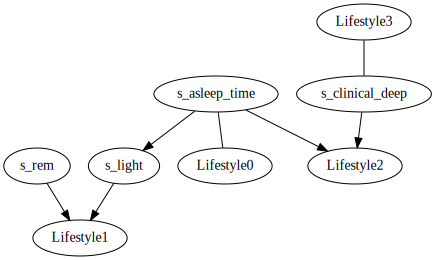

In [151]:
dot = pycausal.generatePyDotGraph(search.nodes,search.edges)
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

In [152]:
search = s.fci(df_sleep_mins_full_ind, priorKnowledge=prior, significance=0.05)

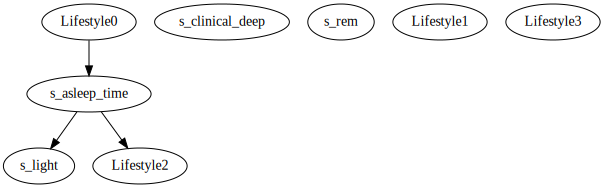

In [153]:
dot = pycausal.generatePyDotGraph(search.nodes,search.edges)
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

Bool

In [154]:
search = s.fgesMixed(df_bool_ind, priorKnowledge=prior, penaltydiscount=0.1)

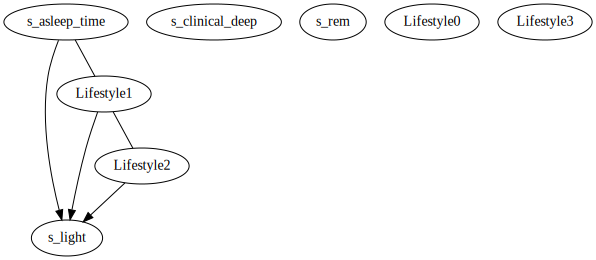

In [155]:
dot = pycausal.generatePyDotGraph(search.nodes,search.edges)
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

In [156]:
search = s.gfciMixed(df_bool_ind, priorKnowledge=prior, penaltydiscount=0.1, significance=0.05)

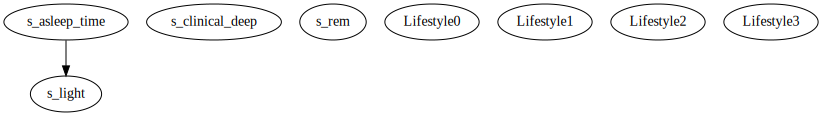

In [157]:
dot = pycausal.generatePyDotGraph(search.nodes,search.edges)
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

In [158]:
test = sm.OLS(full_Y['s_clinical_deep'], sm.add_constant(full_X['C'])).fit()

KeyError: 'C'

In [ ]:
test.summary()

In [ ]:
fig, axes = plt.subplots(4, figsize=(6, 12))

sm.graphics.tsa.plot_acf(full_Y['s_light'],
                         lags=full_Y['s_light'].shape[0]//4,
                         ax=axes[0],
                        title='Autocorrelation (light)');

sm.graphics.tsa.plot_acf(full_Y['s_clinical_deep'],
                         lags=full_Y['s_clinical_deep'].shape[0]//4,
                         ax=axes[1],
                        title='Autocorrelation (deep)');

sm.graphics.tsa.plot_acf(full_Y['s_rem'],
                         lags=full_Y['s_rem'].shape[0]//4,
                         ax=axes[2],
                        title='Autocorrelation (rem)');

sm.graphics.tsa.plot_acf(full_X['s_duration'],
                         lags=full_X['s_duration'].shape[0]//4,
                         ax=axes[3],
                        title='Autocorrelation (TST)');
